In [2]:
import sys
import os
import numpy as np
from functools import reduce
from pathlib import Path

from dotenv import load_dotenv
load_dotenv()
# Add the project root directory to Python path
project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)
import pandas as pd
import matplotlib.pyplot as plt

from utils.plots import EDAPlots
from utils.eia_api import EIADataPuller
from utils.custom_types import StorageRegion, FuelType, EIAConsumptionType, storage_region_to_noaa_states
from utils.data_transforms import DataTransforms
from utils.noaa import get_noaa_day_data

# Program/Anaysis Constants

In [3]:
ANALYSIS_REGION = StorageRegion.EAST
data_puller = EIADataPuller(ANALYSIS_REGION)
final_feature_dfs = []

# EIA Natural Gas Storage Numbers

In [4]:
storage_df = data_puller.get_storage_data()

print(f"\nDtypes: {storage_df.dtypes}")
storage_df

{'response': {'total': '815', 'dateFormat': 'YYYY-MM-DD', 'frequency': 'weekly', 'data': [{'period': '2010-04-02', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EPG0_SWO_R31_BCF', 'series-description': 'Weekly East Region Natural Gas Working Underground Storage (Billion Cubic Feet)', 'value': '333', 'units': 'BCF'}, {'period': '2010-06-11', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EPG0_SWO_R31_BCF', 'series-description': 'Weekly East Region Natural Gas Working Underground Storage (Billion Cubic Feet)', 'value': '571', 'units': 'BCF'}, {'period': '2010-07-02', 'duoarea': 'R31', 'area-name': 'NA', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'SWO', 'process-name': 'Underground Storage - Working Gas', 'series': 'NW2_EP

period  EAST_NG_Storage_BCF  Week  Year
0   2025-08-08                  677    31  2025
1   2025-08-01                  656    30  2025
2   2025-07-25                  651    29  2025
3   2025-07-18                  634    28  2025
4   2025-07-11                  628    27  2025
..         ...                  ...   ...   ...
810 2010-01-29                  582     4  2010
811 2010-01-22                  616     3  2010
812 2010-01-15                  642     2  2010
813 2010-01-08                  703     1  2010
814 2010-01-01                  769     0  2010

[815 rows x 4 columns]

In [5]:
storage_df[storage_df['period'] > '2011-12-31'].sort_values("period")

period  EAST_NG_Storage_BCF  Week  Year
709 2012-01-06                  819     1  2012
708 2012-01-13                  791     2  2012
707 2012-01-20                  728     3  2012
706 2012-01-27                  682     4  2012
705 2012-02-03                  656     5  2012
..         ...                  ...   ...   ...
4   2025-07-11                  628    27  2025
3   2025-07-18                  634    28  2025
2   2025-07-25                  651    29  2025
1   2025-08-01                  656    30  2025
0   2025-08-08                  677    31  2025

[710 rows x 4 columns]

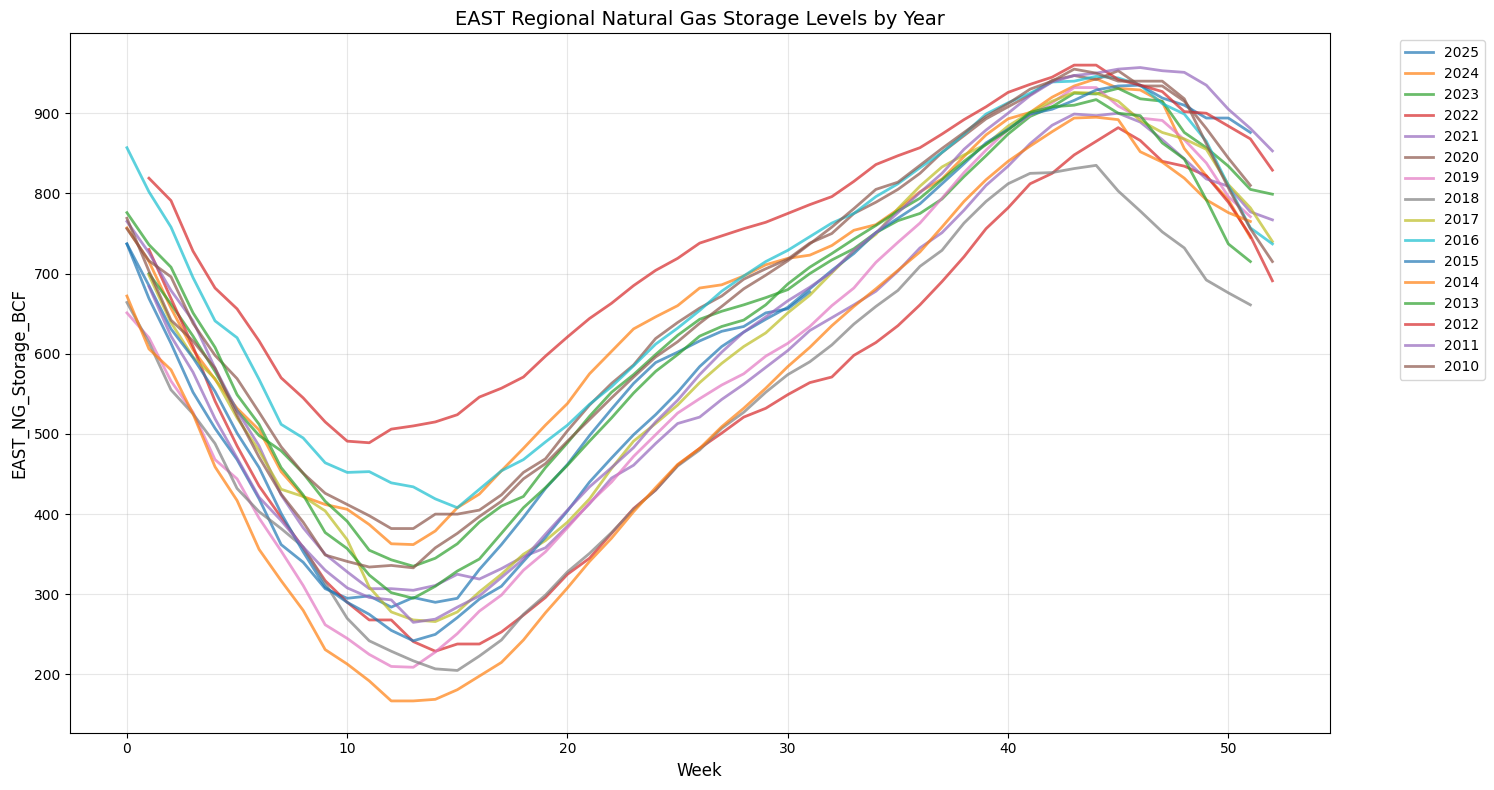

In [6]:
EDAPlots.generate_year_plot(storage_df, 'Week',f'{ANALYSIS_REGION.name}_NG_Storage_BCF', f"{ANALYSIS_REGION.name} Regional Natural Gas Storage Levels by Year")

# Power Generation

Pros: Power Generation from burnt fuel is very granual (daily)  
Cons: Data only extends back to 2019, we will simply graph this data to determine if any other series can be used as a replacement to allow us to use years before 2019

In [7]:
power_gen_df = data_puller.get_power_gen_data(FuelType.NATURAL_GAS)
print(f"\nDtypes: {power_gen_df.dtypes}")
power_gen_df

{'warnings': [{'warning': 'incomplete return', 'description': 'The API can only return 5000 rows in JSON format.  Please consider constraining your request with facet, start, or end, or using offset to paginate results.'}], 'response': {'total': '9671', 'dateFormat': 'YYYY-MM-DD', 'frequency': 'daily', 'data': [{'period': '2025-08-15', 'respondent': 'CAR', 'respondent-name': 'Carolinas', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '214543', 'value-units': 'megawatthours'}, {'period': '2025-08-15', 'respondent': 'MIDA', 'respondent-name': 'Mid-Atlantic', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '1451199', 'value-units': 'megawatthours'}, {'period': '2025-08-15', 'respondent': 'NE', 'respondent-name': 'New England', 'fueltype': 'NG', 'type-name': 'Natural Gas', 'timezone': 'Eastern', 'timezone-description': 'Eastern', 'value': '259334', 'value-units

Week  Year  EAST_NG_Power_Gen_MWh
0       0  2019           9.004496e+05
1       0  2020           1.050378e+06
2       0  2021           1.181554e+06
3       0  2022           9.600410e+05
4       0  2024           1.585946e+06
..    ...   ...                    ...
346    52  2021           1.201993e+06
347    52  2022           1.214021e+06
348    52  2023           1.318246e+06
349    52  2024           1.221313e+06
350    53  2023           1.381151e+06

[351 rows x 3 columns]

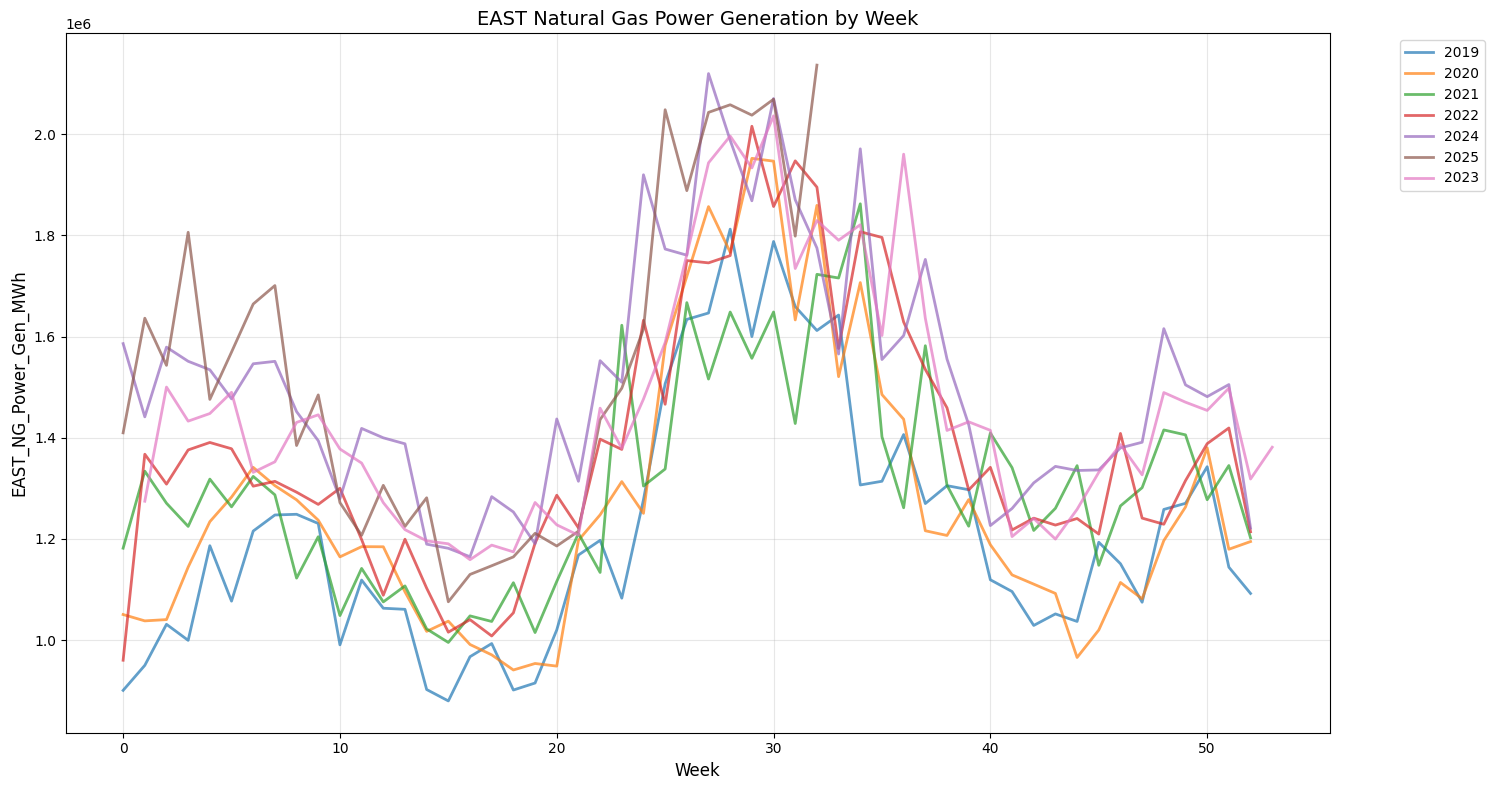

In [8]:
EDAPlots.generate_year_plot(power_gen_df, "Week", f"{ANALYSIS_REGION.name}_NG_Power_Gen_MWh", f"{ANALYSIS_REGION.name} Natural Gas Power Generation by Week")

# NG Usage Data

While there are many options for natural gas usage (all of which we will use for our model), we will take a look at the Elecricity consumption type to see if we can approximate the pattern provided by the EIA power burn dataset (peak in summer months, slight rise in Winter)

In [9]:
usage_type = EIAConsumptionType.ELECTRICITY
elecricity_usage_df = data_puller.get_ng_usage_data(usage_type)
elecricity_usage_df

{'response': {'total': '555', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2010-11', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Electric Power Consumers (MMcf)', 'value': '112', 'units': 'MMCF'}, {'period': '2011-04', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Electric Power Consumers (MMcf)', 'value': '90', 'units': 'MMCF'}, {'period': '2011-07', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VEU', 'process-name': 'Electric Power Consumption', 'series': 'N3045NE2', 'series-description': 'Nebraska Natural Gas Deliveries to Electr

period          value  Year  Month
0   2010-01-01   92539.354839  2010      1
1   2010-02-01   94530.000000  2010      2
2   2010-03-01   90369.677419  2010      3
3   2010-04-01   98778.000000  2010      4
4   2010-05-01  122034.193548  2010      5
..         ...            ...   ...    ...
180 2025-01-01  144130.645161  2025      1
181 2025-02-01  137891.785714  2025      2
182 2025-03-01  124683.870968  2025      3
183 2025-04-01  136622.000000  2025      4
184 2025-05-01  158243.225806  2025      5

[185 rows x 4 columns]

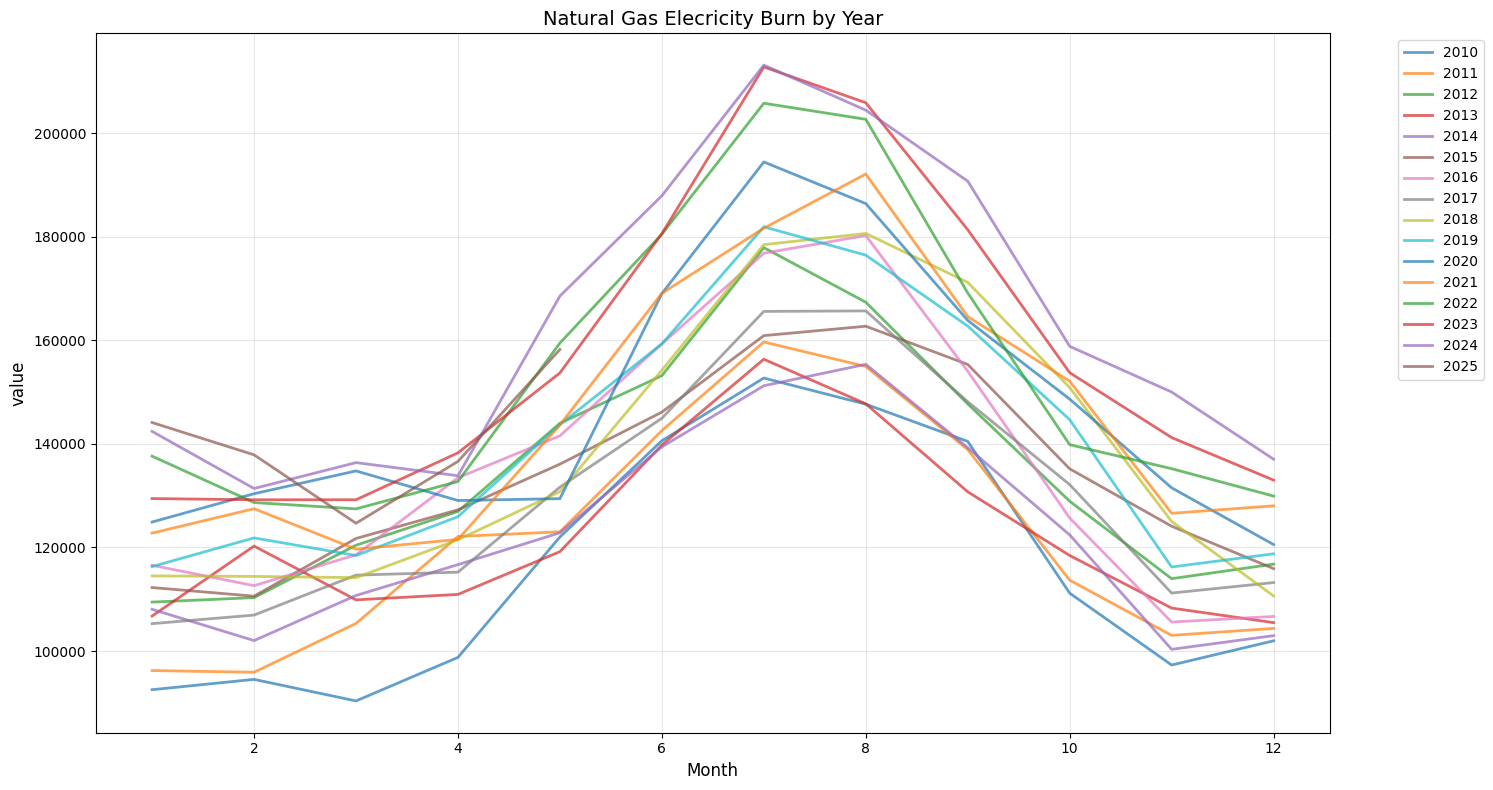

In [10]:
EDAPlots.generate_year_plot(elecricity_usage_df, "Month", "value", "Natural Gas Elecricity Burn by Year")

To use this data within our regression model, we will upscale it to a weekly frequency. Since we do not have prior information on how the intra-month distribution might look like, we can simply spread the monthly aggregated total evenly across each of the weeks within a given month

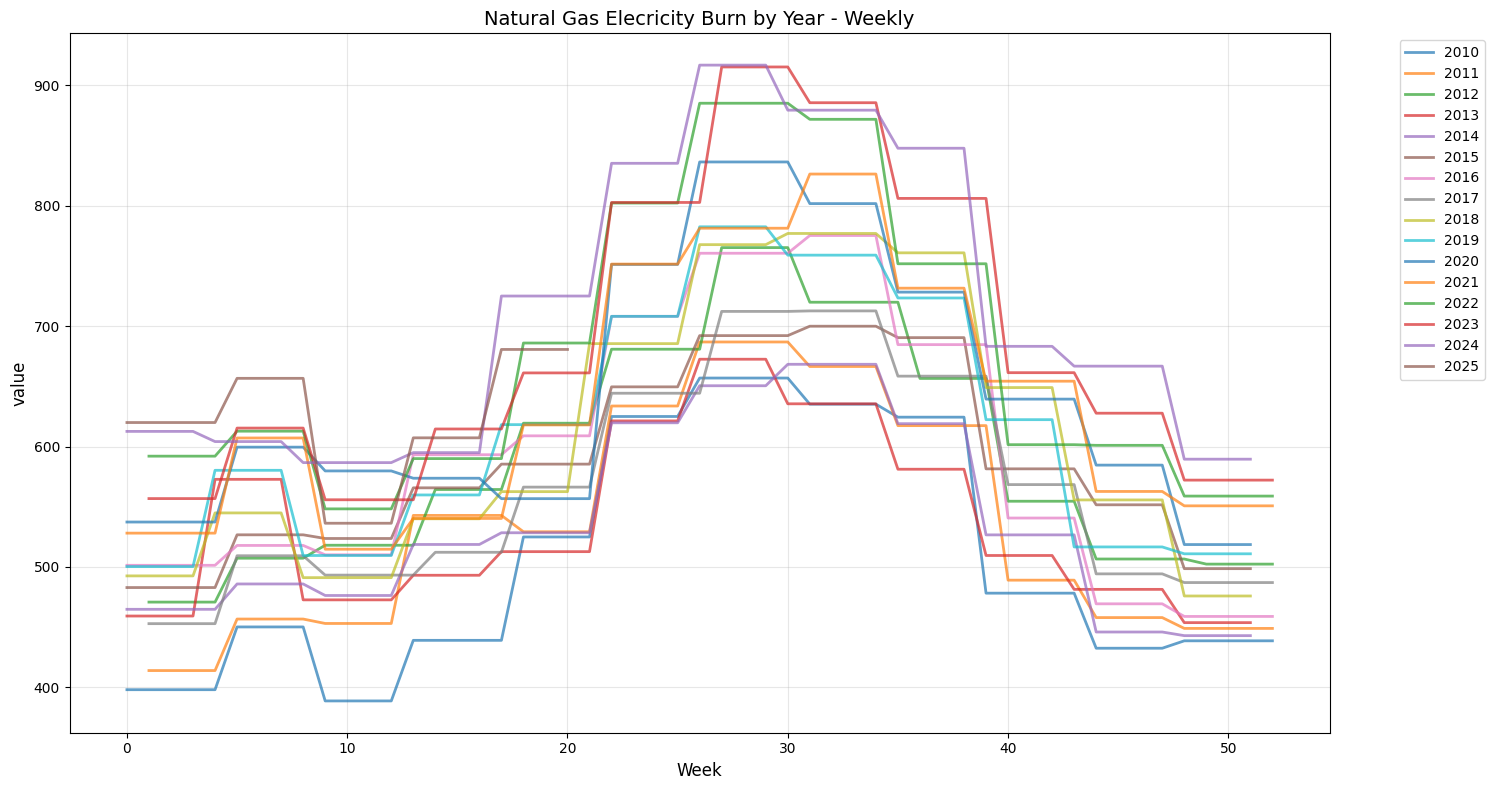

Year
2010    505.210628
2011    536.129587
2012    590.138448
2013    537.752487
2014    537.983534
2015    587.169808
2016    594.584249
2017    567.816418
2018    609.970529
2019    614.723848
2020    642.252887
2021    636.226757
2022    676.729707
2023    689.101509
2024    712.010275
2025    620.118690
Name: value, dtype: float64

In [11]:
weekly_burn_df = DataTransforms.upscale_monthly_to_weekly(elecricity_usage_df, "period", "value")

EDAPlots.generate_year_plot(weekly_burn_df, "Week", "value", "Natural Gas Elecricity Burn by Year - Weekly")

final_feature_dfs.append(weekly_burn_df[["period", "value"]].rename(columns={"value": "NG_Power_Gen"}))
weekly_burn_df.groupby("Year")["value"].mean()

The above plot signals that there is a significant amount of year to year deviation, likely due to increased natural gas plant operating demand over the years. We can isolate the seasonal trend of this feature by looking at deviations from the yearly average, separating raw (magnitude of gas burnt) and seasonal deviations.

In [12]:
# Check for yearly mean trend - seems to be increasing as time goes on
yearly_mean = weekly_burn_df.groupby("Year")["value"].mean()
yearly_mean

Year
2010    505.210628
2011    536.129587
2012    590.138448
2013    537.752487
2014    537.983534
2015    587.169808
2016    594.584249
2017    567.816418
2018    609.970529
2019    614.723848
2020    642.252887
2021    636.226757
2022    676.729707
2023    689.101509
2024    712.010275
2025    620.118690
Name: value, dtype: float64

period       datetime64[ns]
Year                  int32
Month                 int32
Week                  int64
year                  int32
deviation           float64
dtype: object


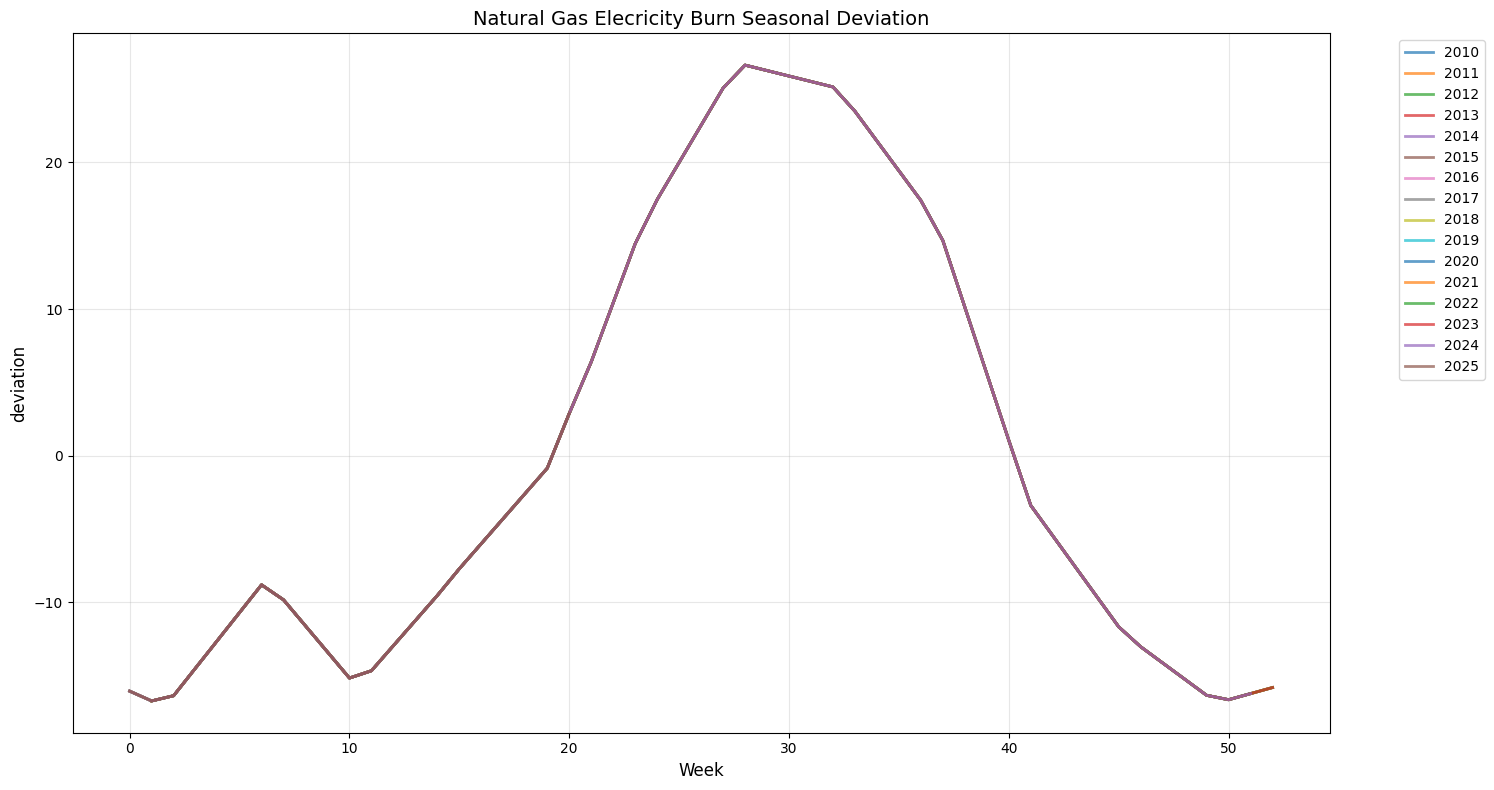

In [13]:
power_burn_interpolated_df = DataTransforms.weekly_interpolate_from_middle_week(weekly_burn_df, "period", "value")
power_burn_seasonal_deviation = DataTransforms.calculate_deviation_from_yearly_avg(power_burn_interpolated_df, "period", "value")
print(power_burn_seasonal_deviation.dtypes)



final_feature_dfs.append(power_burn_seasonal_deviation[["period", "deviation"]].rename(columns={"deviation": "NG_Seasonal_Power_Gen"}))
EDAPlots.generate_year_plot(power_burn_seasonal_deviation, "Week", "deviation", "Natural Gas Elecricity Burn Seasonal Deviation")

In [14]:
power_burn_seasonal_deviation

period  Year  Month  Week  year  deviation
0   2010-01-01  2010      1     0  2010 -16.045804
1   2010-01-08  2010      1     1  2010 -16.712684
2   2010-01-15  2010      1     2  2010 -16.356354
3   2010-01-22  2010      1     3  2010 -14.467200
4   2010-01-29  2010      1     4  2010 -12.578046
..         ...   ...    ...   ...   ...        ...
799 2025-04-25  2025      4    16  2025  -5.989703
800 2025-05-02  2025      5    17  2025  -4.276236
801 2025-05-09  2025      5    18  2025  -2.562770
802 2025-05-16  2025      5    19  2025  -0.849303
803 2025-05-23  2025      5    20  2025   2.879473

[804 rows x 6 columns]

### NG Usage - Residential

{'response': {'total': '555', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2010-04', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VCS', 'process-name': 'Commercial Consumption', 'series': 'N3020NE2', 'series-description': 'Natural Gas Deliveries to Commercial Consumers (Including Vehicle Fuel through 1996) in Nebraska (MMcf)', 'value': '2480', 'units': 'MMCF'}, {'period': '2010-07', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VCS', 'process-name': 'Commercial Consumption', 'series': 'N3020NE2', 'series-description': 'Natural Gas Deliveries to Commercial Consumers (Including Vehicle Fuel through 1996) in Nebraska (MMcf)', 'value': '1084', 'units': 'MMCF'}, {'period': '2010-08', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VCS', 'process-name': 'Commercial Consumption', 'series': 'N3020NE2',

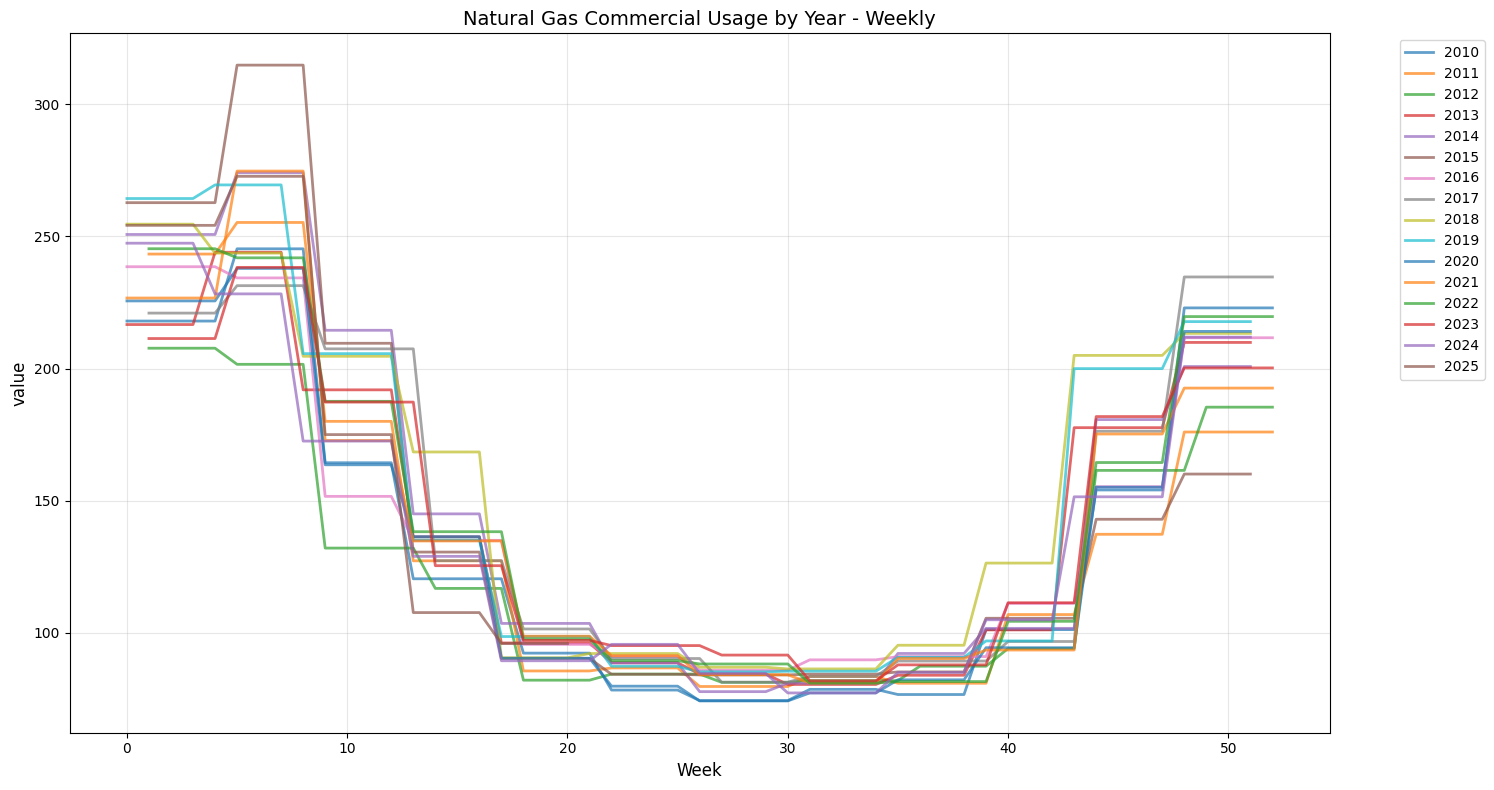

period  Year  Month  Week       value
0   2010-01-01  2010      1     0  217.993757
1   2010-01-08  2010      1     1  217.993757
2   2010-01-15  2010      1     2  217.993757
3   2010-01-22  2010      1     3  217.993757
4   2010-01-29  2010      1     4  217.993757
..         ...   ...    ...   ...         ...
799 2025-04-25  2025      4    16  107.684444
800 2025-05-02  2025      5    17   95.975026
801 2025-05-09  2025      5    18   95.975026
802 2025-05-16  2025      5    19   95.975026
803 2025-05-23  2025      5    20   95.975026

[804 rows x 5 columns]

In [15]:

usage_type = EIAConsumptionType.COMMERCIAL

commercial_usage_df = data_puller.get_ng_usage_data(usage_type)
weekly_commercial_df = DataTransforms.upscale_monthly_to_weekly(commercial_usage_df, "period", "value")

EDAPlots.generate_year_plot(weekly_commercial_df, "Week", "value", "Natural Gas Commercial Usage by Year - Weekly")



final_feature_dfs.append(weekly_commercial_df[["period", "value"]].rename(columns={"value": "NG_Commercial_Usage"}))
weekly_commercial_df

In [16]:

# Year to year deviations don't seem as extreme - we can omit the trend curve
yearly_mean = weekly_commercial_df.groupby("Year")["value"].mean()
yearly_mean

Year
2010    136.688970
2011    135.282450
2012    125.487762
2013    142.156540
2014    149.618072
2015    145.423958
2016    142.015419
2017    145.875042
2018    154.977925
2019    152.644613
2020    134.797001
2021    143.319615
2022    143.974760
2023    142.490494
2024    138.493145
2025    184.610933
Name: value, dtype: float64

### NG Usage - Vehicle Fuel

The overall magnitude is much smaller, but still relevant. The yearly trend is very pronounced, but since the demand seems to be consistent, we do not create a seasonality curve.

{'response': {'total': '555', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2010-01', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VDV', 'process-name': 'Vehicle Fuel Consumption', 'series': 'NA1570_SNE_2', 'series-description': 'Nebraska Natural Gas Vehicle Fuel Consumption (MMcf)', 'value': '3', 'units': 'MMCF'}, {'period': '2010-04', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VDV', 'process-name': 'Vehicle Fuel Consumption', 'series': 'NA1570_SNE_2', 'series-description': 'Nebraska Natural Gas Vehicle Fuel Consumption (MMcf)', 'value': '2', 'units': 'MMCF'}, {'period': '2011-03', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VDV', 'process-name': 'Vehicle Fuel Consumption', 'series': 'NA1570_SNE_2', 'series-description': 'Nebraska Natural Gas Vehicle Fuel Consumption (MMcf)', 'value': '3

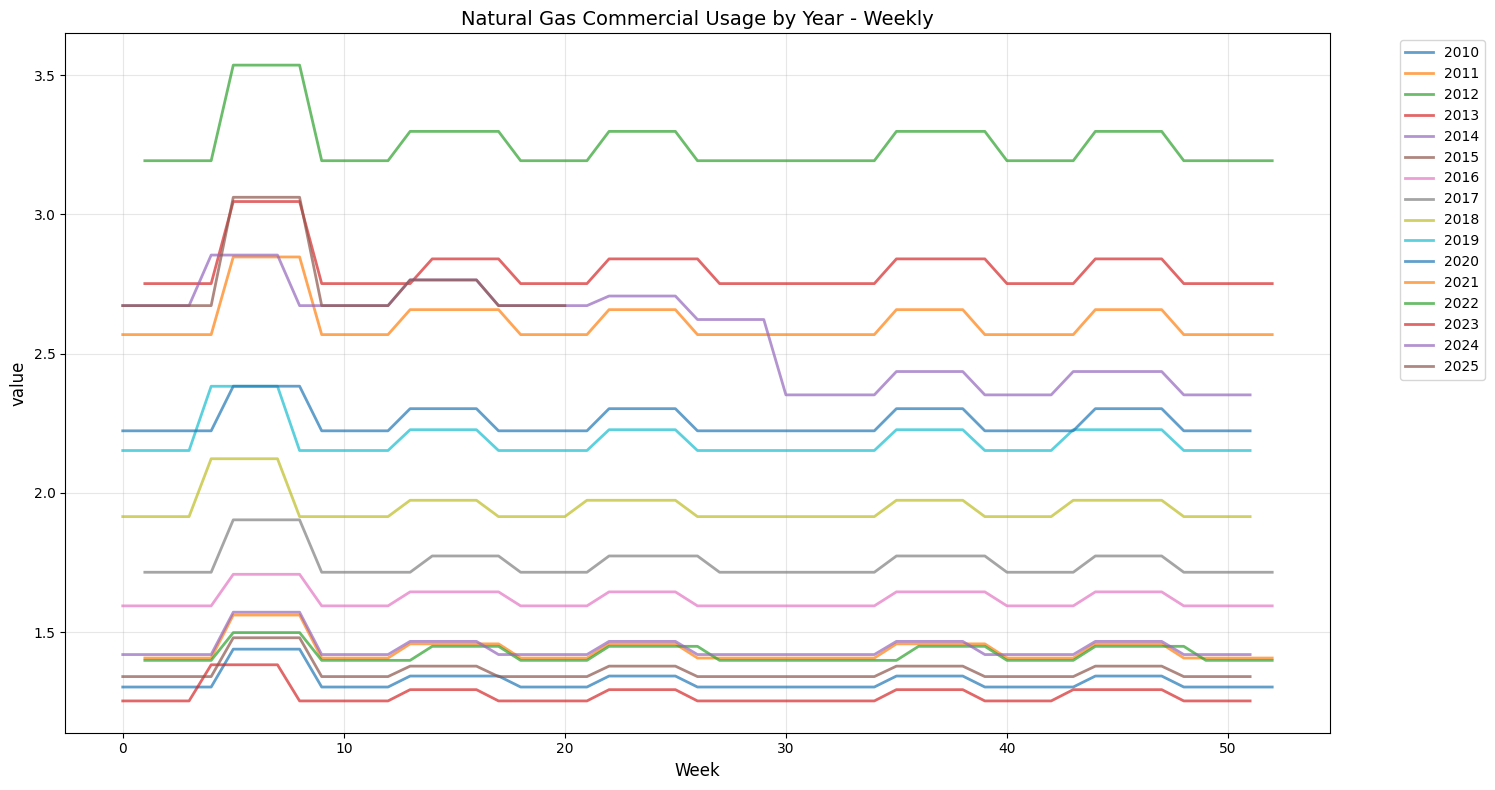

period  Year  Month  Week     value
0   2010-01-01  2010      1     0  1.302810
1   2010-01-08  2010      1     1  1.302810
2   2010-01-15  2010      1     2  1.302810
3   2010-01-22  2010      1     3  1.302810
4   2010-01-29  2010      1     4  1.302810
..         ...   ...    ...   ...       ...
799 2025-04-25  2025      4    16  2.764444
800 2025-05-02  2025      5    17  2.672216
801 2025-05-09  2025      5    18  2.672216
802 2025-05-16  2025      5    19  2.672216
803 2025-05-23  2025      5    20  2.672216

[804 rows x 5 columns]

In [17]:

usage_type = EIAConsumptionType.VEHICLEFUEL

vehicle_fuel_df = data_puller.get_ng_usage_data(usage_type)
weekly_vehicle_fuel_df = DataTransforms.upscale_monthly_to_weekly(vehicle_fuel_df, "period", "value")

EDAPlots.generate_year_plot(weekly_vehicle_fuel_df, "Week", "value", "Natural Gas Commercial Usage by Year - Weekly")



final_feature_dfs.append(weekly_vehicle_fuel_df[["period", "value"]].rename(columns={"value": "NG_Vehicle_Fuel_Usage"}))
weekly_vehicle_fuel_df

### NG Usage - Delivery

{'response': {'total': '555', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2010-06', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VGT', 'process-name': 'Delivered to Consumers', 'series': 'N3060NE2', 'series-description': 'Natural Gas Delivered to Consumers in Nebraska (Including Vehicle Fuel) (MMcf)', 'value': '8950', 'units': 'MMCF'}, {'period': '2011-05', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VGT', 'process-name': 'Delivered to Consumers', 'series': 'N3060NE2', 'series-description': 'Natural Gas Delivered to Consumers in Nebraska (Including Vehicle Fuel) (MMcf)', 'value': '9791', 'units': 'MMCF'}, {'period': '2012-03', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VGT', 'process-name': 'Delivered to Consumers', 'series': 'N3060NE2', 'series-description': 'Natural Gas Delivered to C

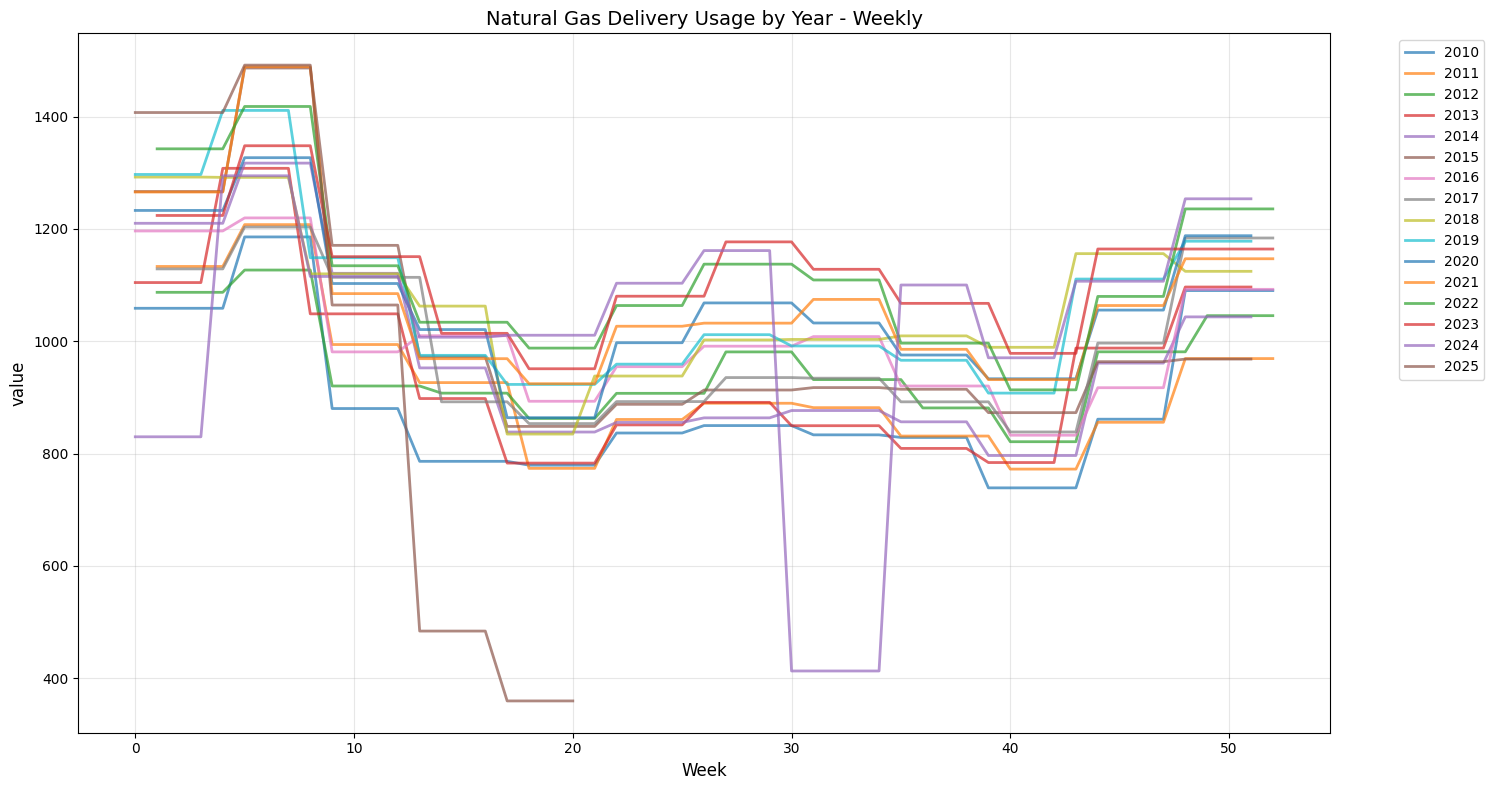

period  Year  Month  Week        value
0   2010-01-01  2010      1     0  1058.755463
1   2010-01-08  2010      1     1  1058.755463
2   2010-01-15  2010      1     2  1058.755463
3   2010-01-22  2010      1     3  1058.755463
4   2010-01-29  2010      1     4  1058.755463
..         ...   ...    ...   ...          ...
799 2025-04-25  2025      4    16   484.062222
800 2025-05-02  2025      5    17   359.667014
801 2025-05-09  2025      5    18   359.667014
802 2025-05-16  2025      5    19   359.667014
803 2025-05-23  2025      5    20   359.667014

[804 rows x 5 columns]

In [18]:
usage_type = EIAConsumptionType.DELIVERY

delivery_usage_df = data_puller.get_ng_usage_data(usage_type)
weekly_delivery_df = DataTransforms.upscale_monthly_to_weekly(delivery_usage_df, "period", "value")

EDAPlots.generate_year_plot(weekly_delivery_df, "Week", "value", "Natural Gas Delivery Usage by Year - Weekly")


final_feature_dfs.append(weekly_delivery_df[["period", "value"]].rename(columns={"value": "NG_Delivery_Usage"}))
weekly_delivery_df

### NG Usage - Industrial

{'response': {'total': '555', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2010-10', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VIN', 'process-name': 'Industrial Consumption', 'series': 'N3035NE2', 'series-description': 'Nebraska Natural Gas Industrial Consumption (MMcf)', 'value': '7128', 'units': 'MMCF'}, {'period': '2011-08', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VIN', 'process-name': 'Industrial Consumption', 'series': 'N3035NE2', 'series-description': 'Nebraska Natural Gas Industrial Consumption (MMcf)', 'value': '7934', 'units': 'MMCF'}, {'period': '2012-12', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VIN', 'process-name': 'Industrial Consumption', 'series': 'N3035NE2', 'series-description': 'Nebraska Natural Gas Industrial Consumption (MMcf)', 'value': '7058', 'units': 'MM

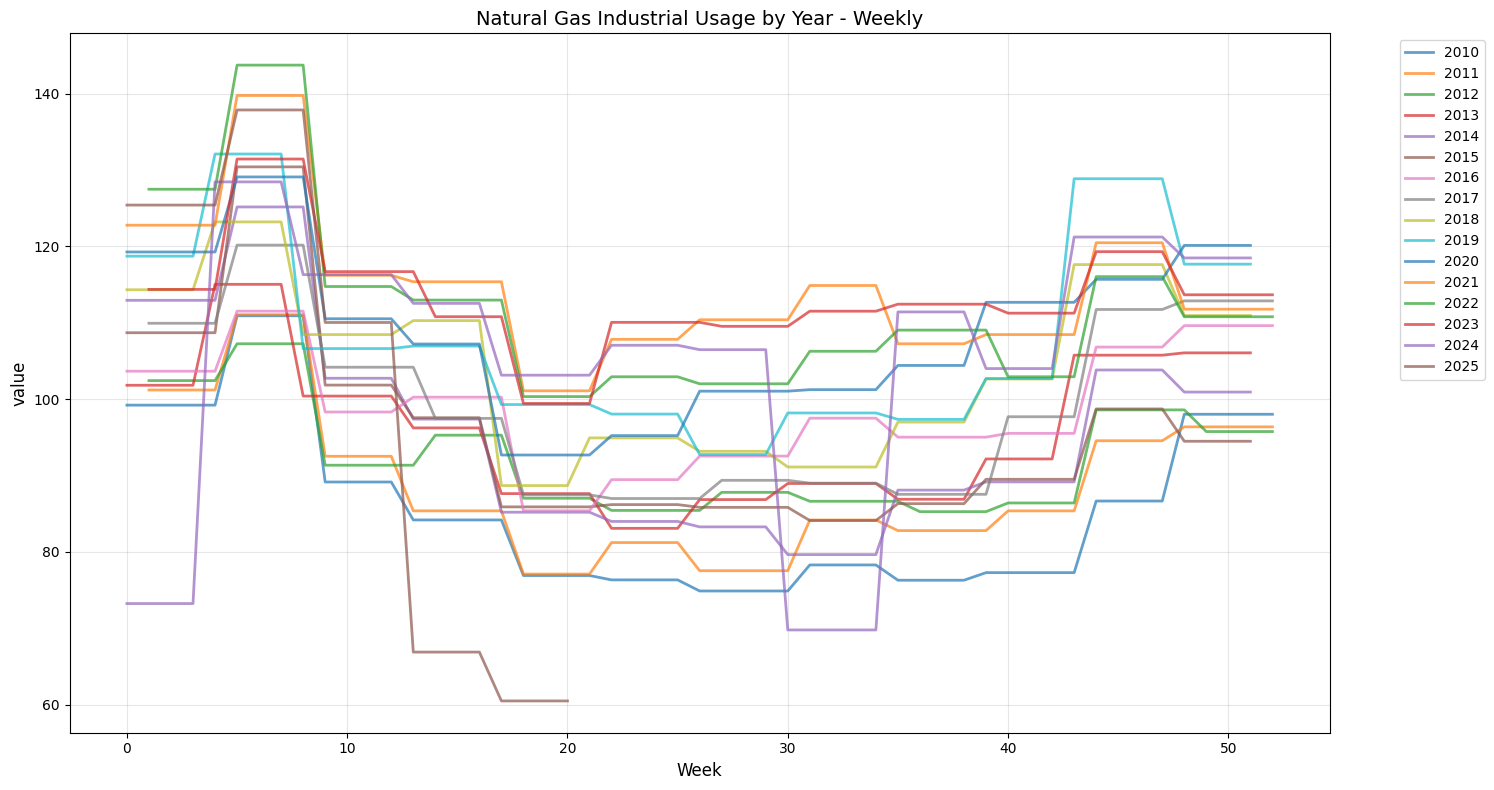

period  Year  Month  Week      value
0   2010-01-01  2010      1     0  99.213319
1   2010-01-08  2010      1     1  99.213319
2   2010-01-15  2010      1     2  99.213319
3   2010-01-22  2010      1     3  99.213319
4   2010-01-29  2010      1     4  99.213319
..         ...   ...    ...   ...        ...
799 2025-04-25  2025      4    16  66.893333
800 2025-05-02  2025      5    17  60.499480
801 2025-05-09  2025      5    18  60.499480
802 2025-05-16  2025      5    19  60.499480
803 2025-05-23  2025      5    20  60.499480

[804 rows x 5 columns]

In [19]:
usage_type = EIAConsumptionType.INDUSTRIAL

industrial_usage_df = data_puller.get_ng_usage_data(usage_type)
weekly_industrial_df = DataTransforms.upscale_monthly_to_weekly(industrial_usage_df, "period", "value")

EDAPlots.generate_year_plot(weekly_industrial_df, "Week", "value", "Natural Gas Industrial Usage by Year - Weekly")


final_feature_dfs.append(weekly_industrial_df[["period", "value"]].rename(columns={"value": "NG_Industrial_Usage"}))
weekly_industrial_df

### NG USage - Residential

{'response': {'total': '555', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2010-02', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VRS', 'process-name': 'Residential Consumption', 'series': 'N3010NE2', 'series-description': 'Nebraska Natural Gas Residential Consumption (MMcf)', 'value': '6848', 'units': 'MMCF'}, {'period': '2010-06', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VRS', 'process-name': 'Residential Consumption', 'series': 'N3010NE2', 'series-description': 'Nebraska Natural Gas Residential Consumption (MMcf)', 'value': '1041', 'units': 'MMCF'}, {'period': '2010-09', 'duoarea': 'SNE', 'area-name': 'USA-NE', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'VRS', 'process-name': 'Residential Consumption', 'series': 'N3010NE2', 'series-description': 'Nebraska Natural Gas Residential Consumption (MMcf)', 'value': '641', 'units'

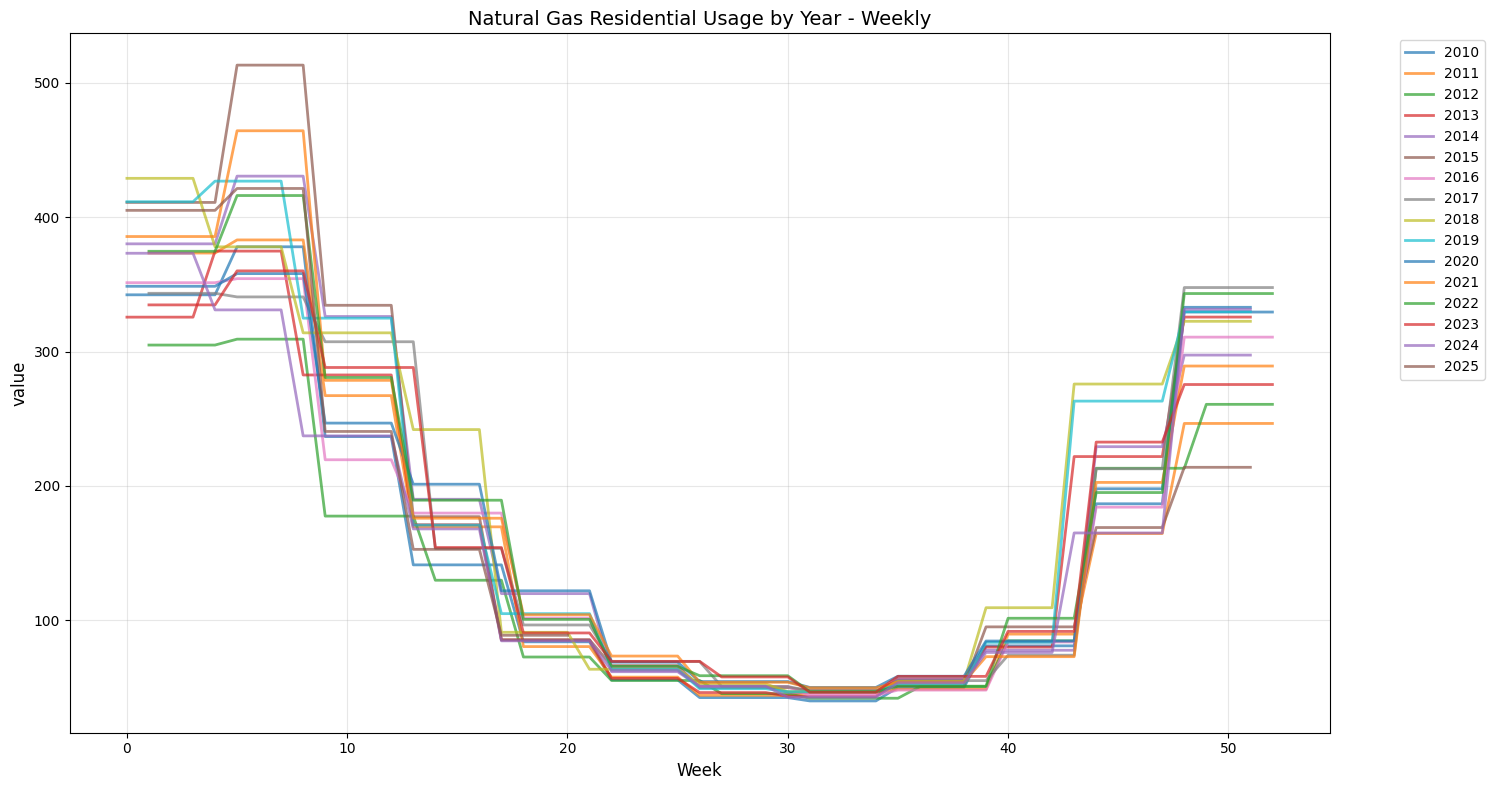

period  Year  Month  Week       value
0   2010-01-01  2010      1     0  342.231009
1   2010-01-08  2010      1     1  342.231009
2   2010-01-15  2010      1     2  342.231009
3   2010-01-22  2010      1     3  342.231009
4   2010-01-29  2010      1     4  342.231009
..         ...   ...    ...   ...         ...
799 2025-04-25  2025      4    16  152.800000
800 2025-05-02  2025      5    17   88.844953
801 2025-05-09  2025      5    18   88.844953
802 2025-05-16  2025      5    19   88.844953
803 2025-05-23  2025      5    20   88.844953

[804 rows x 5 columns]

In [20]:
usage_type = EIAConsumptionType.RESIDENTIAL

residential_usage_df = data_puller.get_ng_usage_data(usage_type)
weekly_residential_df = DataTransforms.upscale_monthly_to_weekly(residential_usage_df, "period", "value")

EDAPlots.generate_year_plot(weekly_residential_df, "Week", "value", "Natural Gas Residential Usage by Year - Weekly")


final_feature_dfs.append(weekly_residential_df[["period", "value"]].rename(columns={"value": "NG_Residential_Usage"}))
weekly_residential_df

# NOAA Heating/Cooling Day Data

In [21]:

degree_data_df = get_noaa_day_data(2010, 2024, storage_region_to_noaa_states[StorageRegion.EAST])

weekly_heating_df = DataTransforms.downscale_daily_to_weekly(degree_data_df[["period", "Heating_Days"]], "period", "Heating_Days")
weekly_cooling_df = DataTransforms.downscale_daily_to_weekly(degree_data_df[["period", "Cooling_Days"]], "period", "Cooling_Days")

final_feature_dfs.append(weekly_heating_df[["period", "Heating_Days"]])
final_feature_dfs.append(weekly_cooling_df[["period", "Cooling_Days"]])


weekly_heating_df

Getting data for 2010
Getting data for 2011
Getting data for 2012
Getting data for 2013
Getting data for 2014
Getting data for 2015
Getting data for 2016
Getting data for 2017
Getting data for 2018
Getting data for 2019
Getting data for 2020
Getting data for 2021
Getting data for 2022
Getting data for 2023
Getting data for 2024


period  Heating_Days
0   2010-01-01    549.000000
1   2010-01-08    703.714286
2   2010-01-15    699.285714
3   2010-01-22    483.142857
4   2010-01-29    520.428571
..         ...           ...
779 2024-12-06    596.571429
780 2024-12-13    464.857143
781 2024-12-20    468.428571
782 2024-12-27    643.428571
783 2025-01-03    349.000000

[784 rows x 2 columns]

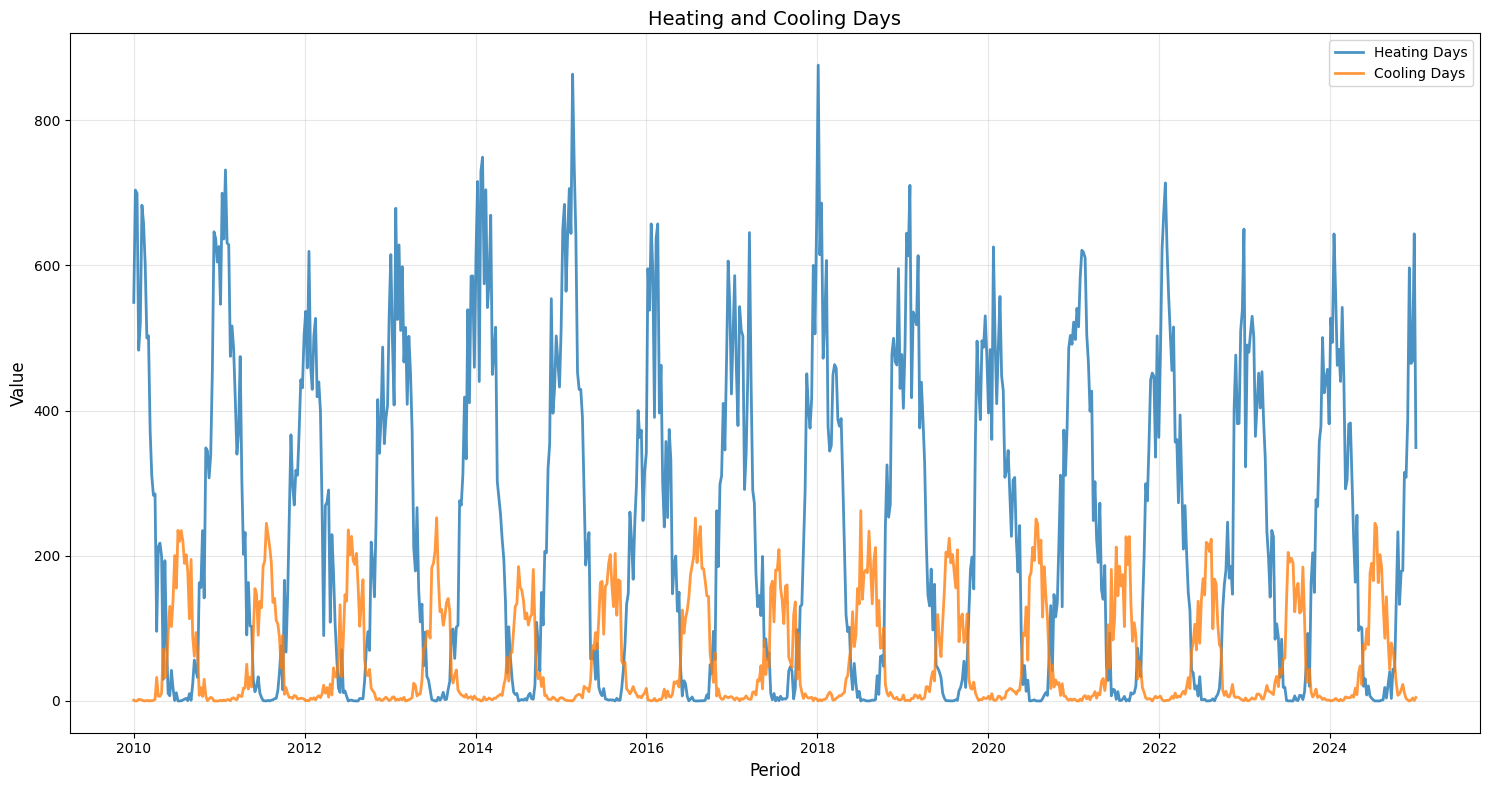

In [22]:
heating_days_plot_df = weekly_heating_df.copy().assign(period=lambda x: x['period'])
cooling_plot_df = weekly_cooling_df.copy().assign(period=lambda x: x['period'])

EDAPlots.plot_dual_time_series_separate_dfs(
    title="Heating and Cooling Days", 
    df1=heating_days_plot_df, 
    series1_col="Heating_Days", 
    df2=cooling_plot_df, 
    series2_col="Cooling_Days", 
    series1_label="Heating Days", 
    series2_label="Cooling Days"
)

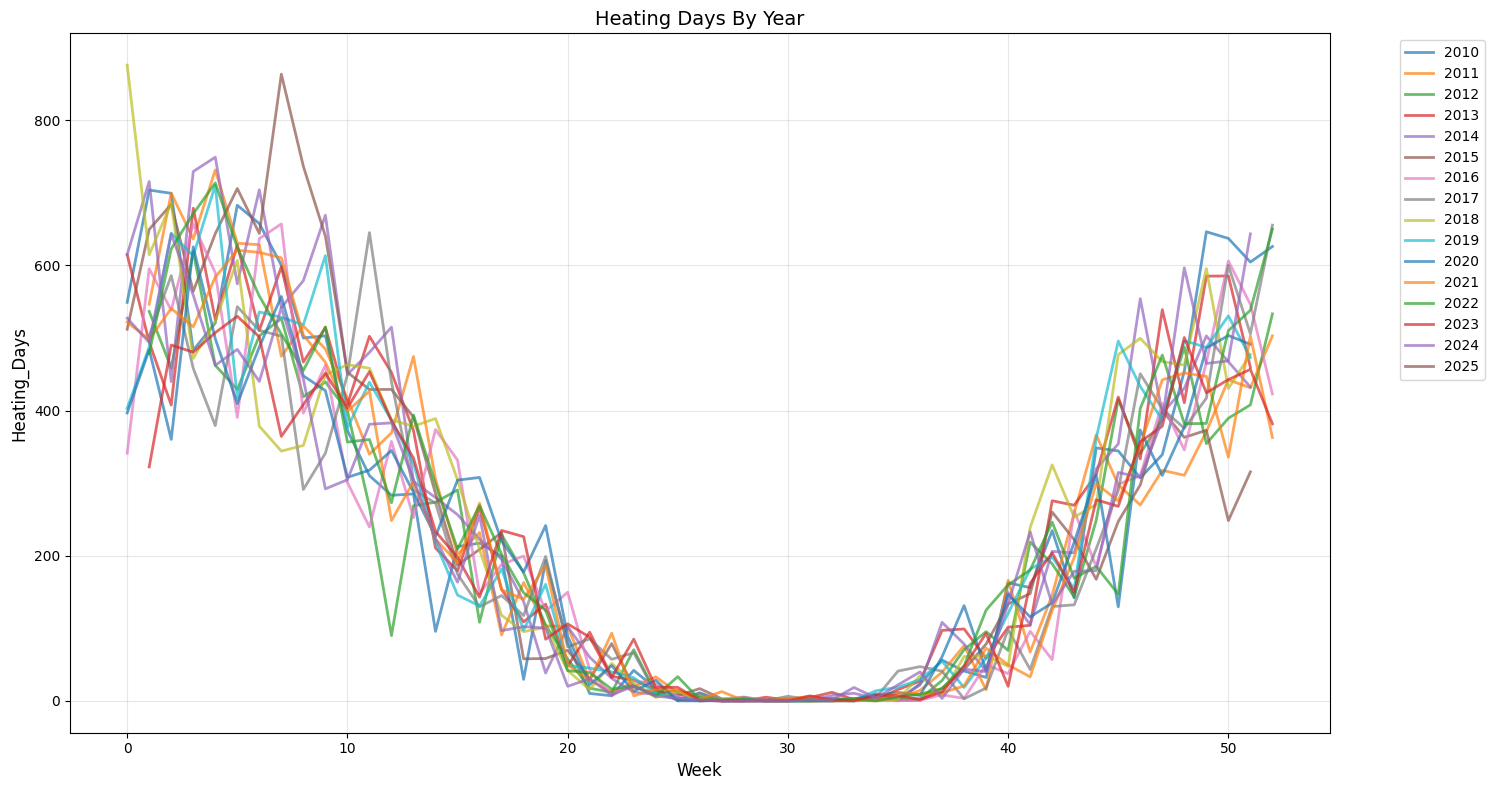

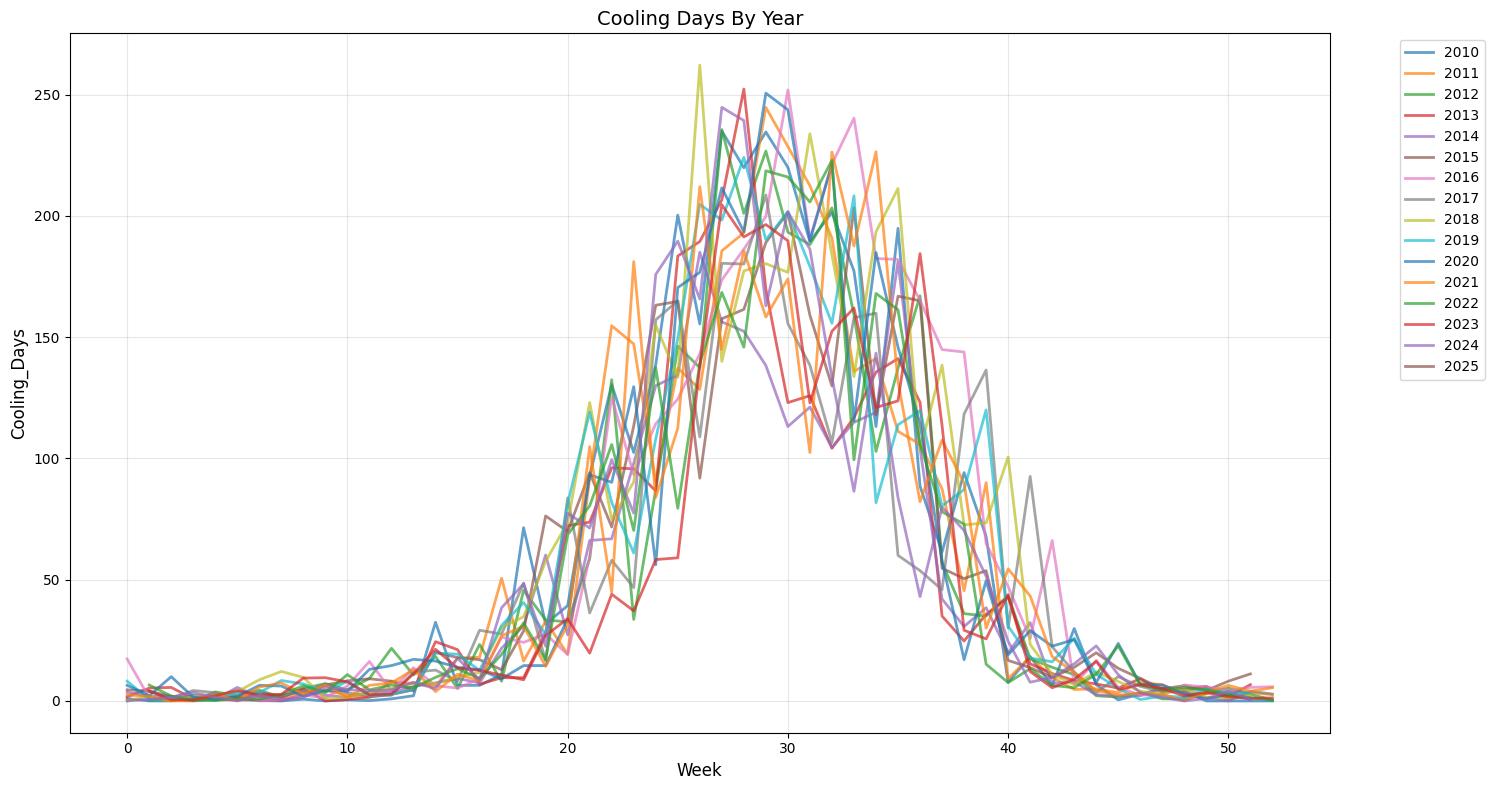

In [23]:
heating_plot_df = weekly_heating_df.reset_index(drop=False).assign(Year=lambda x: x['period'].dt.year, Week=lambda x: x['period'].dt.strftime("%U").astype(int))
EDAPlots.generate_year_plot(heating_plot_df, "Week", "Heating_Days", "Heating Days By Year")

cooling_plot_df = weekly_cooling_df.reset_index(drop=False).assign(Year=lambda x: x['period'].dt.year, Week=lambda x: x['period'].dt.strftime("%U").astype(int))
EDAPlots.generate_year_plot(cooling_plot_df, "Week", "Cooling_Days", "Cooling Days By Year")

# Supply Drivers - NG Withdrawls

In [24]:
withdrawls_df = data_puller.get_ng_withdrawls_data()



{'response': {'total': '1295', 'dateFormat': 'YYYY-MM', 'frequency': 'monthly', 'data': [{'period': '2010-01', 'duoarea': 'SMD', 'area-name': 'USA-MD', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'FGW', 'process-name': 'Gross Withdrawals', 'series': 'N9010MD2', 'series-description': 'Maryland Natural Gas Gross Withdrawals (MMcf)', 'value': '3', 'units': 'MMCF'}, {'period': '2010-05', 'duoarea': 'SMD', 'area-name': 'USA-MD', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'FGW', 'process-name': 'Gross Withdrawals', 'series': 'N9010MD2', 'series-description': 'Maryland Natural Gas Gross Withdrawals (MMcf)', 'value': '3', 'units': 'MMCF'}, {'period': '2010-07', 'duoarea': 'SMD', 'area-name': 'USA-MD', 'product': 'EPG0', 'product-name': 'Natural Gas', 'process': 'FGW', 'process-name': 'Gross Withdrawals', 'series': 'N9010MD2', 'series-description': 'Maryland Natural Gas Gross Withdrawals (MMcf)', 'value': '3', 'units': 'MMCF'}, {'period': '2011-07', 'duoarea':

In [25]:
weekly_withdrawls_df = DataTransforms.upscale_monthly_to_weekly(withdrawls_df, "period", "value")

final_feature_dfs.append(weekly_withdrawls_df[["period", "value"]].rename(columns={"value": "NG_Gross_Withdrawls"}))
weekly_withdrawls_df

period  Year  Month  Week        value
0   2010-01-01  2010      1     0   280.869927
1   2010-01-08  2010      1     1   280.869927
2   2010-01-15  2010      1     2   280.869927
3   2010-01-22  2010      1     3   280.869927
4   2010-01-29  2010      1     4   280.869927
..         ...   ...    ...   ...          ...
799 2025-04-25  2025      4    16  4843.377778
800 2025-05-02  2025      5    17  4744.819979
801 2025-05-09  2025      5    18  4744.819979
802 2025-05-16  2025      5    19  4744.819979
803 2025-05-23  2025      5    20  4744.819979

[804 rows x 5 columns]

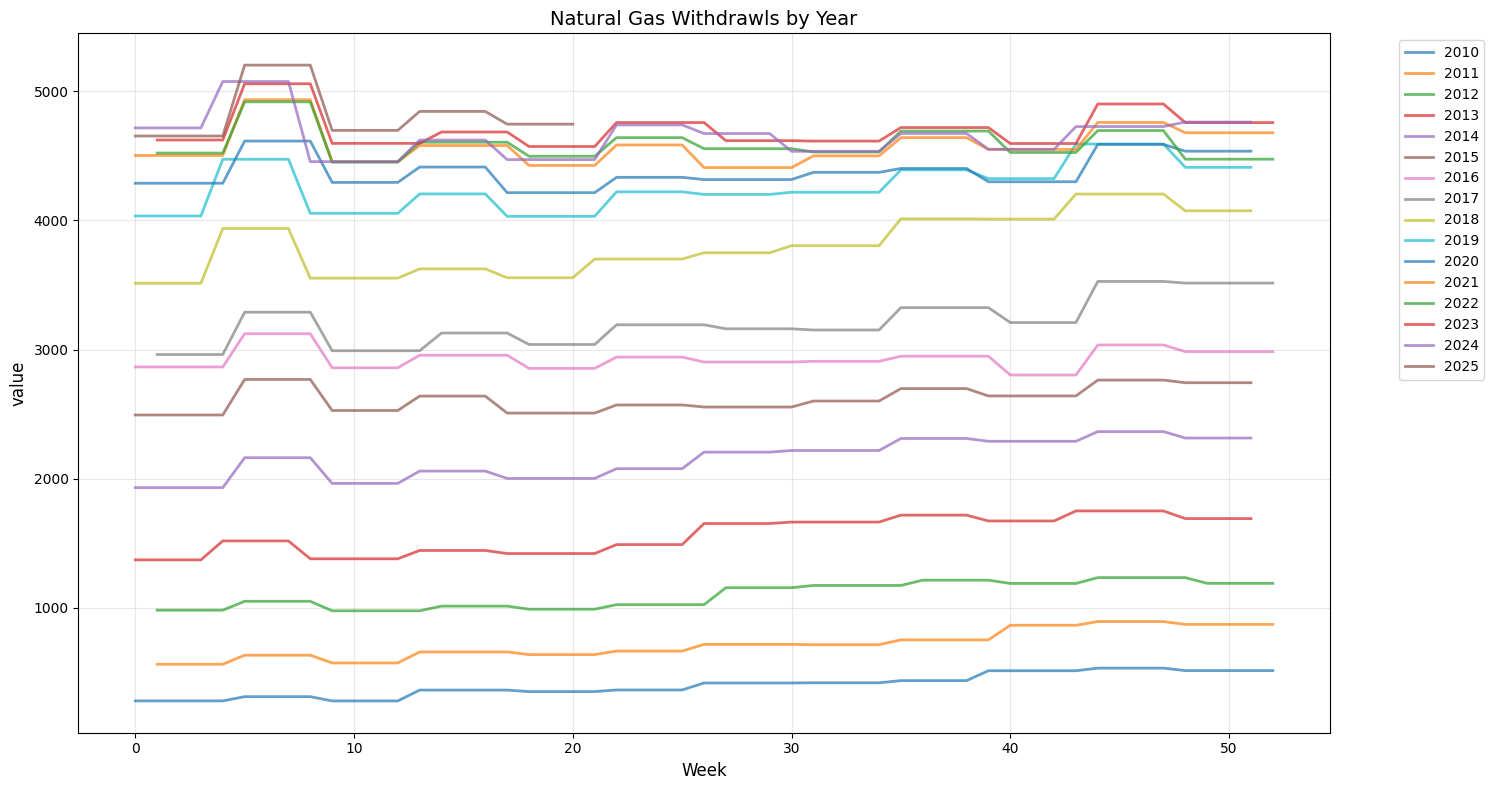

In [26]:

EDAPlots.generate_year_plot(weekly_withdrawls_df, "Week", "value", "Natural Gas Withdrawls by Year")

# Exporting Data

In [27]:
for df in final_feature_dfs:
    print(df.columns)

Index(['period', 'NG_Power_Gen'], dtype='object')
Index(['period', 'NG_Seasonal_Power_Gen'], dtype='object')
Index(['period', 'NG_Commercial_Usage'], dtype='object')
Index(['period', 'NG_Vehicle_Fuel_Usage'], dtype='object')
Index(['period', 'NG_Delivery_Usage'], dtype='object')
Index(['period', 'NG_Industrial_Usage'], dtype='object')
Index(['period', 'NG_Residential_Usage'], dtype='object')
Index(['period', 'Heating_Days'], dtype='object')
Index(['period', 'Cooling_Days'], dtype='object')
Index(['period', 'NG_Gross_Withdrawls'], dtype='object')


In [28]:
features = reduce(lambda x, y: pd.merge(x, y, on = 'period'), final_feature_dfs)
features


period  NG_Power_Gen  NG_Seasonal_Power_Gen  NG_Commercial_Usage  \
0   2010-01-01    398.018730             -16.045804           217.993757   
1   2010-01-08    398.018730             -16.712684           217.993757   
2   2010-01-15    398.018730             -16.356354           217.993757   
3   2010-01-22    398.018730             -14.467200           217.993757   
4   2010-01-29    398.018730             -12.578046           217.993757   
..         ...           ...                    ...                  ...   
779 2024-12-06    589.473465             -15.225903           211.904266   
780 2024-12-13    589.473465             -16.328982           211.904266   
781 2024-12-20    589.473465             -16.629175           211.904266   
782 2024-12-27    589.473465             -16.214187           211.904266   
783 2025-01-03    619.916753             -16.045804           254.206035   

     NG_Vehicle_Fuel_Usage  NG_Delivery_Usage  NG_Industrial_Usage  \
0                 1.302810        1058.755463            99.213319   
1                 1.302810        1058.755463            99.213319   
2                 1.302810        1058.755463            99.213319   
3                 1.302810        1058.755463            99.213319   
4                 1.302810        1058.755463            99.213319   
..                     ...                ...                  ...   
779               2.351717        1253.660770           118.476587   
780               2.351717        1253.660770           118.476587   
781               2.351717        1253.660770           118.476587   
782               2.351717        1253.660770           118.476587   
783               2.672216        1407.271592           125.398543   

     NG_Residential_Usage  Heating_Days  Cooling_Days  NG_Gross_Withdrawls  
0              342.231009    549.000000      1.000000           280.869927  
1              342.231009    703.714286      0.000000           280.869927  
2              342.231009    699.285714      0.000000           280.869927  
3              342.231009    483.142857      2.285714           280.869927  
4              342.231009    520.428571      1.714286           280.869927  
..                    ...           ...           ...                  ...  
779            331.450572    596.571429      0.000000          4761.273673  
780            331.450572    464.857143      1.000000          4761.273673  
781            331.450572    468.428571      4.000000          4761.273673  
782            331.450572    643.428571      0.714286          4761.273673  
783            405.082206    349.000000      4.750000          4653.190427  

[784 rows x 11 columns]

In [29]:
output_table = pd.merge(features, storage_df[["period", f'{ANALYSIS_REGION.name}_NG_Storage_BCF']], on = 'period')
print(output_table.dtypes)
output_table

period                   datetime64[ns]
NG_Power_Gen                    float64
NG_Seasonal_Power_Gen           float64
NG_Commercial_Usage             float64
NG_Vehicle_Fuel_Usage           float64
NG_Delivery_Usage               float64
NG_Industrial_Usage             float64
NG_Residential_Usage            float64
Heating_Days                    float64
Cooling_Days                    float64
NG_Gross_Withdrawls             float64
EAST_NG_Storage_BCF               int64
dtype: object


period  NG_Power_Gen  NG_Seasonal_Power_Gen  NG_Commercial_Usage  \
0   2010-01-01    398.018730             -16.045804           217.993757   
1   2010-01-08    398.018730             -16.712684           217.993757   
2   2010-01-15    398.018730             -16.356354           217.993757   
3   2010-01-22    398.018730             -14.467200           217.993757   
4   2010-01-29    398.018730             -12.578046           217.993757   
..         ...           ...                    ...                  ...   
779 2024-12-06    589.473465             -15.225903           211.904266   
780 2024-12-13    589.473465             -16.328982           211.904266   
781 2024-12-20    589.473465             -16.629175           211.904266   
782 2024-12-27    589.473465             -16.214187           211.904266   
783 2025-01-03    619.916753             -16.045804           254.206035   

     NG_Vehicle_Fuel_Usage  NG_Delivery_Usage  NG_Industrial_Usage  \
0                 1.302810        1058.755463            99.213319   
1                 1.302810        1058.755463            99.213319   
2                 1.302810        1058.755463            99.213319   
3                 1.302810        1058.755463            99.213319   
4                 1.302810        1058.755463            99.213319   
..                     ...                ...                  ...   
779               2.351717        1253.660770           118.476587   
780               2.351717        1253.660770           118.476587   
781               2.351717        1253.660770           118.476587   
782               2.351717        1253.660770           118.476587   
783               2.672216        1407.271592           125.398543   

     NG_Residential_Usage  Heating_Days  Cooling_Days  NG_Gross_Withdrawls  \
0              342.231009    549.000000      1.000000           280.869927   
1              342.231009    703.714286      0.000000           280.869927   
2              342.231009    699.285714      0.000000           280.869927   
3              342.231009    483.142857      2.285714           280.869927   
4              342.231009    520.428571      1.714286           280.869927   
..                    ...           ...           ...                  ...   
779            331.450572    596.571429      0.000000          4761.273673   
780            331.450572    464.857143      1.000000          4761.273673   
781            331.450572    468.428571      4.000000          4761.273673   
782            331.450572    643.428571      0.714286          4761.273673   
783            405.082206    349.000000      4.750000          4653.190427   

     EAST_NG_Storage_BCF  
0                    769  
1                    703  
2                    642  
3                    616  
4                    582  
..                   ...  
779                  856  
780                  822  
781                  792  
782                  745  
783                  737  

[784 rows x 12 columns]

In [30]:
output_table.to_csv(f'../data/{ANALYSIS_REGION.name}_data_raw.csv', index=False)